# Passphrase Hackers
Implementation of the paper [A Practical Deep Learning-Based Acoustic Side Channel Attack on Keyboards](https://arxiv.org/abs/2308.01074)

## Importing dependencies

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt

## Downloading Dataset

In [2]:
!git clone https://github.com/JBFH-Dev/Keystroke-Datasets

fatal: destination path 'Keystroke-Datasets' already exists and is not an empty directory.


In [3]:
# waveform function for me to not bang my keyboard
def disp_waveform(signal, sr=None):
    plt.figure(figsize=(7,2))
    return librosa.display.waveshow(signal, sr=sr)

## Data preprocessing for MBP-> 0.wav (testing, optional to run)

In [4]:
sample0, sr0 = librosa.load('Keystroke-Datasets/MBPWavs/0.wav')

In [5]:
sr0

22050

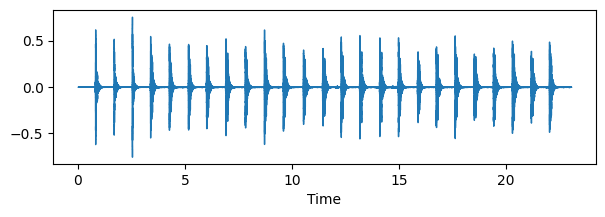

In [6]:
plt.figure(figsize=(7,2))
librosa.display.waveshow(sample0, sr=sr0)

In [7]:
n_fft = 1024
hop_length = 225

In [8]:
#Calculating the STFT of the Sample
fft = librosa.stft(sample0, n_fft = 1024 , hop_length = 225)

In [9]:
#Calculating the Energy of the Signal using FFT
energy = np.abs(np.sum(fft, axis=0)).astype(float)

In [10]:
len(energy), len(sample0), len(fft)

(2257, 507801, 513)

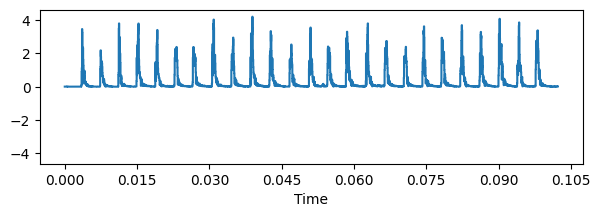

In [11]:
plt.figure(figsize=(7,2))
librosa.display.waveshow(energy)

In [12]:
threshold = 0.06

#Converting into Binary
threshed = energy > threshold

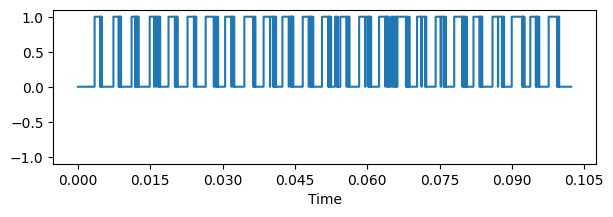

In [13]:
plt.figure(figsize=(7,2))
librosa.display.waveshow(threshed.astype(float))

In [14]:
peaks = np.where(threshed == True)[0]
print(peaks)

[  76   77   78 ... 2196 2199 2200]


In [15]:
peak_count = len(peaks)
print(peak_count)

1034


In [16]:
prev_end = sr0*0.1*(-1)

In [17]:
strokes = []

/var/folders/n6/g4_68zd53wv1p0j52r160t7m0000gn/T/ipykernel_65900/3003071332.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7, 2))


<Figure size 700x200 with 0 Axes>

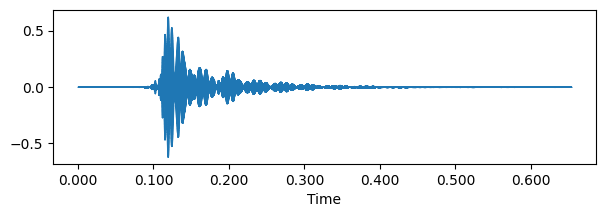

<Figure size 700x200 with 0 Axes>

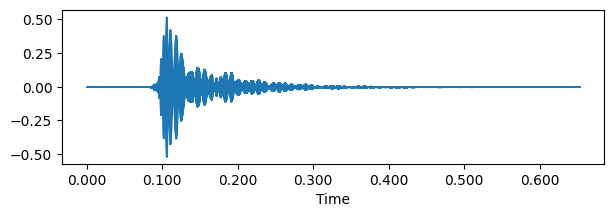

<Figure size 700x200 with 0 Axes>

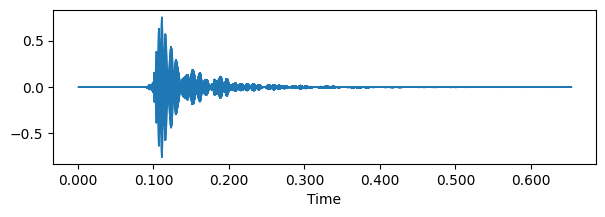

<Figure size 700x200 with 0 Axes>

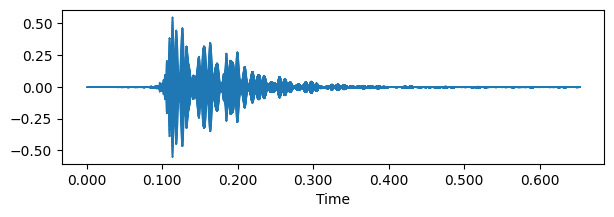

<Figure size 700x200 with 0 Axes>

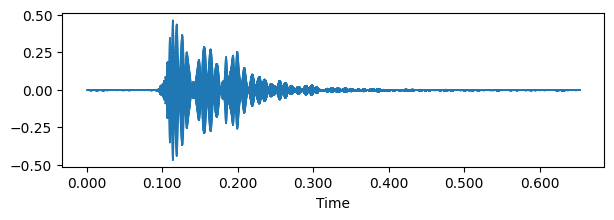

<Figure size 700x200 with 0 Axes>

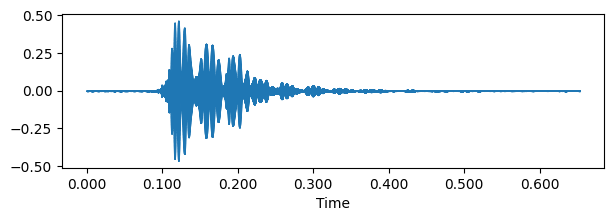

<Figure size 700x200 with 0 Axes>

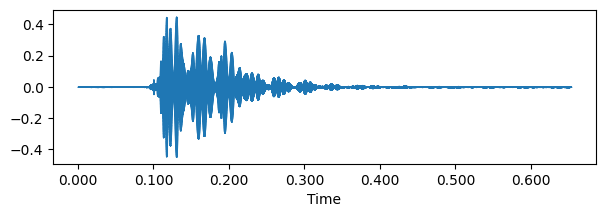

<Figure size 700x200 with 0 Axes>

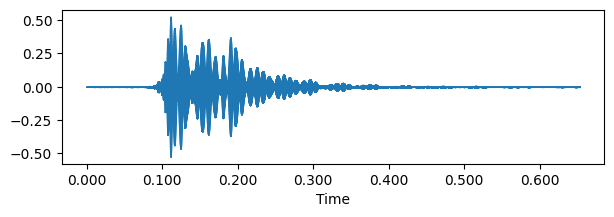

<Figure size 700x200 with 0 Axes>

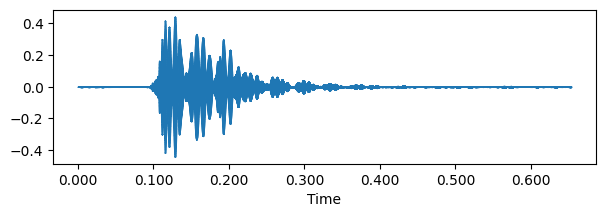

<Figure size 700x200 with 0 Axes>

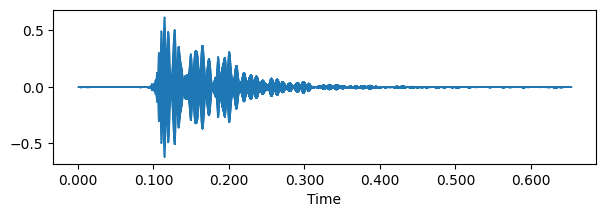

<Figure size 700x200 with 0 Axes>

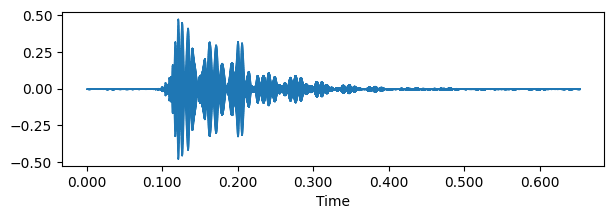

<Figure size 700x200 with 0 Axes>

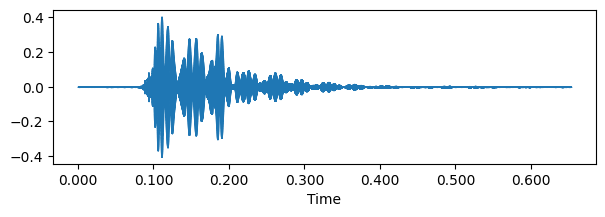

<Figure size 700x200 with 0 Axes>

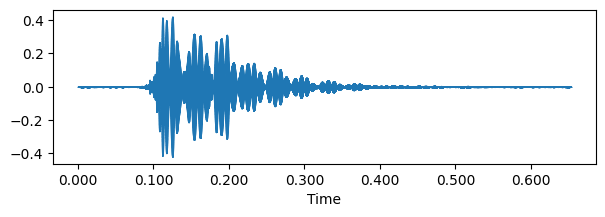

<Figure size 700x200 with 0 Axes>

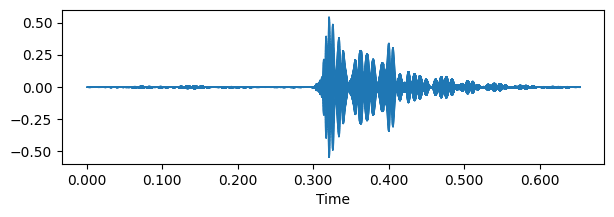

<Figure size 700x200 with 0 Axes>

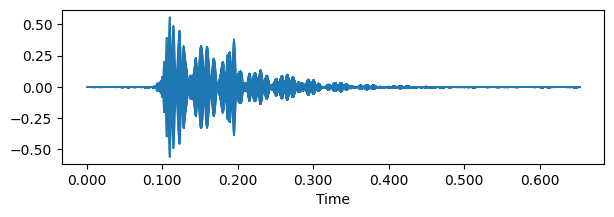

<Figure size 700x200 with 0 Axes>

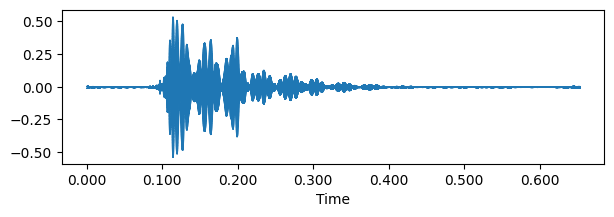

<Figure size 700x200 with 0 Axes>

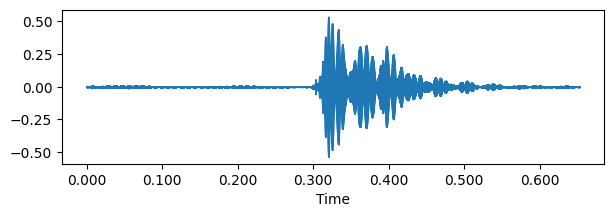

<Figure size 700x200 with 0 Axes>

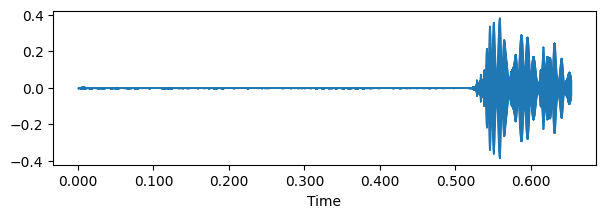

<Figure size 700x200 with 0 Axes>

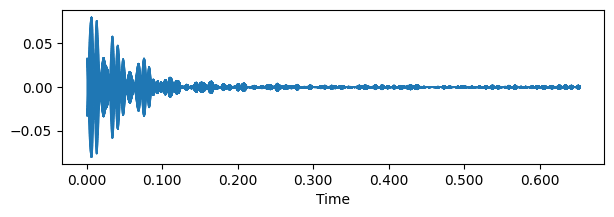

<Figure size 700x200 with 0 Axes>

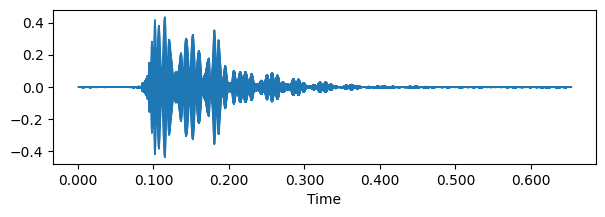

<Figure size 700x200 with 0 Axes>

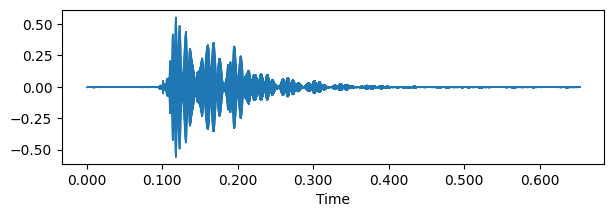

<Figure size 700x200 with 0 Axes>

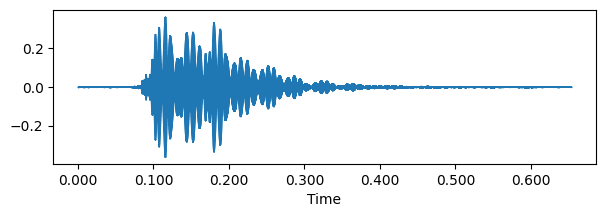

<Figure size 700x200 with 0 Axes>

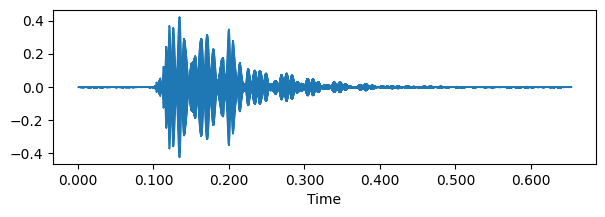

<Figure size 700x200 with 0 Axes>

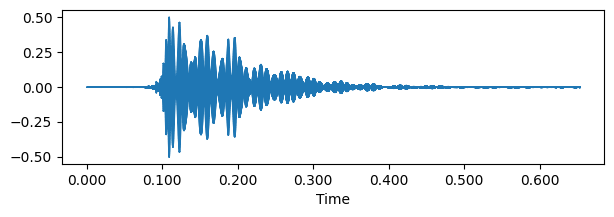

<Figure size 700x200 with 0 Axes>

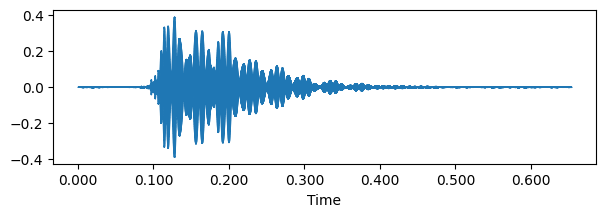

<Figure size 700x200 with 0 Axes>

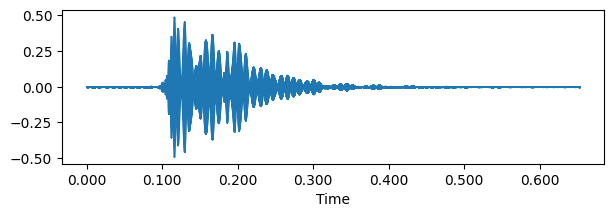

In [18]:
before = 2400
after = 12000

for i in range(peak_count):
  this_peak = peaks[i]
  timestamp = (this_peak*hop_length) + n_fft//2
  if timestamp > prev_end + (0.1 * sr0):
    keystroke = sample0[timestamp-before:timestamp+after]
    strokes.append(torch.tensor(keystroke)[None, :])
    plt.figure(figsize=(7, 2))
    disp_waveform(keystroke, sr=sr0)
    prev_end = timestamp+after

In [19]:
strokes

[tensor([[-1.6139e-06,  2.5359e-05,  2.7650e-05,  ..., -4.1709e-04,
          -3.6484e-04, -3.8991e-04]]),
 tensor([[ 1.2388e-04,  5.9806e-05,  3.4104e-05,  ..., -3.7163e-04,
          -4.2677e-04, -3.9683e-04]]),
 tensor([[0.0003, 0.0003, 0.0002,  ..., 0.0003, 0.0003, 0.0003]]),
 tensor([[-1.7213e-04, -1.4752e-04, -1.9045e-04,  ..., -1.3699e-04,
          -1.2517e-04, -5.6322e-05]]),
 tensor([[-0.0002, -0.0002, -0.0002,  ...,  0.0003,  0.0003,  0.0004]]),
 tensor([[ 0.0013,  0.0013,  0.0013,  ..., -0.0015, -0.0015, -0.0015]]),
 tensor([[-0.0004, -0.0004, -0.0004,  ...,  0.0004,  0.0004,  0.0003]]),
 tensor([[0.0002, 0.0002, 0.0003,  ..., 0.0013, 0.0013, 0.0013]]),
 tensor([[-0.0003, -0.0002, -0.0002,  ..., -0.0015, -0.0015, -0.0015]]),
 tensor([[-0.0010, -0.0010, -0.0009,  ..., -0.0011, -0.0011, -0.0011]]),
 tensor([[ 7.4976e-05,  7.4097e-05,  1.0979e-04,  ..., -1.2711e-03,
          -1.2160e-03, -1.1672e-03]]),
 tensor([[0.0001, 0.0002, 0.0001,  ..., 0.0004, 0.0004, 0.0004]]),
 tenso

In [20]:
spect = librosa.feature.melspectrogram(y=np.asarray(strokes[0]), n_mels=64, hop_length=225)


## Data preprocessing for all keys of MBP

In [21]:
def isolator(signal, sample_rate, n_fft, hop_length, before, after, threshold, show=False):
    strokes = []
    # -- signal'
    if show:
        disp_waveform(signal, sr=sample_rate)
    fft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    energy = np.abs(np.sum(fft, axis=0)).astype(float)
    # norm = np.linalg.norm(energy)
    # energy = energy/norm
    # -- energy'
    if show:
        disp_waveform(energy)
    threshed = energy > threshold
    # -- peaks'
    if show:
        disp_waveform(threshed.astype(float))
    peaks = np.where(threshed == True)[0]
    peak_count = len(peaks)
    prev_end = sample_rate*0.1*(-1)
    # '-- isolating keystrokes'
    for i in range(peak_count):
        this_peak = peaks[i]
        timestamp = (this_peak*hop_length) + n_fft//2
        if timestamp > prev_end + (0.1*sample_rate):
            keystroke = signal[timestamp-before:timestamp+after]
            # strokes.append(torch.tensor(keystroke)[None, :])
            # keystroke = transform(keystroke)
            strokes.append(keystroke)
            if show:
                disp_waveform(keystroke, sr=sample_rate)
            prev_end = timestamp+after
    return strokes

In [22]:
MBP_AUDIO_DIR = 'Keystroke-Datasets/MBPWavs/'
keys_s = '1234567890QWERTYUIOPASDFGHJKLZXCVBNM'
labels = list(keys_s)
keys = [k + '.wav' for k in labels]
data_dict = {'Key':[], 'File':[]}

In [23]:
def create_dataset(n_fft, hop_length, before, after):
    for i, File in enumerate(keys):
        loc = MBP_AUDIO_DIR + File
        samples, sr = librosa.load(loc, sr=None)
        # samples, sr = librosa.load(loc,sr=None,duration=1.0,mono=True)

        strokes = []
        prom = 0.06
        step = 0.005
        strokes = isolator(samples[1*sr:], sr, n_fft, hop_length, before, after, prom, False )
        # while not len(strokes) == 25:
        #   strokes = isolator(samples[1*sr:], sr, n_fft, hop_length, before, after, prom, False )
        #   if len(strokes) < 25:
        #     prom -= step
        #   if len(strokes) > 25:
        #     prom += step
        #   if prom < 0:
        #     print("--not possible for : ", File)
        #     break
        #   step = step * 0.99
        label = [labels[i]]*len(strokes)
        data_dict['Key'] += label
        data_dict['File'] += strokes

    df = pd.DataFrame(data_dict)
    mapper = {}
    counter = 0
    for l in df['Key']:
        if not l in mapper:
            mapper[l] = counter
            counter += 1
    df.replace({'Key': mapper}, inplace = True)

    return df

In [24]:
n_fft = 1024
hop_length = 225
before = 2400
after = 12000

In [25]:
mbp_dataset = create_dataset(n_fft, hop_length, before, after)

/var/folders/n6/g4_68zd53wv1p0j52r160t7m0000gn/T/ipykernel_65900/3695350713.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'Key': mapper}, inplace = True)


In [26]:
mbp_dataset

,Key,File
0,0,"[0.00056563073, 0.00059064646, 0.00057467376, ..."
1,0,"[-0.00088350236, -0.00082214864, -0.000850462,..."
2,0,"[0.0389099, 0.037920922, 0.03718628, 0.0364156..."
3,0,"[-0.0016599343, -0.001683231, -0.001592722, -0..."
4,0,"[-0.036342144, -0.03663899, -0.036876295, -0.0..."
...,...,...
1896,35,"[-0.001111645, -0.0010758567, -0.0011559874, -..."
1897,35,"[-0.20384681, -0.19828525, -0.19439557, -0.189..."
1898,35,"[0.0028810638, 0.0029012985, 0.002902966, 0.00..."
1899,35,"[0.0012991551, 0.0012819592, 0.0012312228, 0.0..."


In [27]:
audio_samples = mbp_dataset['File'].values.tolist()
labels = mbp_dataset['Key'].values.tolist()

audioDataset = np.array(audio_samples,dtype = object)
labels = np.array(labels)

In [28]:
len(audio_samples),len(audioDataset)

(1901, 1901)

In [29]:
mbp_dataset["Key"].value_counts()

Key
9     59
12    59
8     59
13    58
11    58
10    57
22    57
5     56
24    55
19    55
4     54
3     54
14    54
7     53
33    53
25    53
2     53
17    53
27    52
23    52
35    52
20    52
31    52
29    52
28    52
21    51
15    51
30    51
32    50
18    49
26    49
1     49
16    48
6     47
34    46
0     46
Name: count, dtype: int64

In [30]:
mel = librosa.feature.melspectrogram(y=audioDataset[0], n_mels=64, n_fft=1024, hop_length=225)

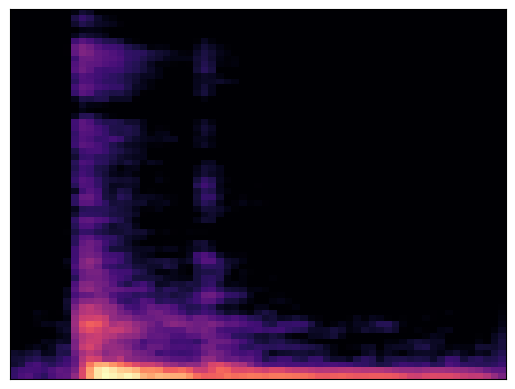

In [31]:
librosa.display.specshow(librosa.power_to_db(mel, ref=np.max))

## Generating MelSpectrograms

In [32]:
from skimage.transform import resize

In [33]:
class ToMelSpectrogram:
    def __init__(self, audio_length=14400):
        self.audio_length = audio_length

    def __call__(self, samples):
        if len(samples) > self.audio_length:
            samples = samples[:self.audio_length]
        elif len(samples) < self.audio_length:
            samples = np.pad(samples, (0, self.audio_length - len(samples)), mode='constant')

        mel_spec = librosa.feature.melspectrogram(y=samples, sr=44100, n_mels=64, n_fft=1024, hop_length=225)

        mel_spec_resized = resize(mel_spec, (64, 64), anti_aliasing=True)

        mel_spec_resized = np.expand_dims(mel_spec_resized, axis=0)

        return torch.tensor(mel_spec_resized)


In [34]:
transform = Compose([ToMelSpectrogram()])

In [35]:
audioDatasetFin = []

for i in range(len(audio_samples)):
    transformed_sample = transform(audio_samples[i])

    audioDatasetFin.append((transformed_sample, labels[i]))

## CoAtNet

In [36]:
import torch
from torch import nn

class CoAtNet(nn.Module):
    def __init__(self, num_classes=36):
        super(CoAtNet, self).__init__()

        # Convolutional part
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Transformer part
        encoder_layer = nn.TransformerEncoderLayer(d_model=32, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)

        # Linear classifier
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.conv_layers(x)

        # Flattening
        x = x.view(x.size(0), -1, x.size(1))

        # Transformer encoder
        x = self.transformer_encoder(x)

        # Max pooling over time
        x, _ = torch.max(x, dim=1)

        # Classifier
        x = self.fc(x)
        return x

In [37]:
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_FILENAME = "model.pth"
MODEL_PATH = os.path.join(MODEL_DIR, MODEL_FILENAME)

## Training

In [38]:
def train(dataset):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    train_set, val_set = train_test_split(dataset, test_size=0.2)
    train_loader = DataLoader(dataset=train_set, batch_size=16, shuffle=True)
    val_loader = DataLoader(dataset=val_set, batch_size=16, shuffle=True)

    model = CoAtNet()
    model = model
    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    criterion = nn.CrossEntropyLoss()

    num_epochs = 700

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs = inputs
            labels = labels

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_train_loss += loss.item() * inputs.size(0)

            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            # Backward and optimize
            loss.backward()
            optimizer.step()

        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss}, Train Accuracy: {train_accuracy}")

    # Save model
    torch.save(model.state_dict(), MODEL_PATH)

    # Plot loss curves
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.legend()
    plt.show()

    # Plot accuracy curves
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.legend()
    plt.show()

In [39]:
def main():
    train(audioDatasetFin)

uncomment the following cell to train your model else load your model weights in a variable named `MODEL_PATH`

In [40]:
# if __name__ == "__main__":
#     main()

In [41]:
# load your trained model weights
MODEL_PATH = "700_passphrase.pth"

## Prediction

In [42]:
n_fft = 1024
hop_length = 225
before = 2400
after = 12000

In [43]:
def predict(audio_path):
    prom = 0.06
    step = 0.005
    samples, sr = librosa.load(audio_path, sr=None)
    strokes = []
    strokes = isolator(samples[1*sr:], sr, n_fft, hop_length, before, after, prom, False )
    transformed_samples = []
    for stroke in strokes:
      transformed_sample = transform(stroke)
      transformed_samples.append(transformed_sample)

    inputs = torch.stack(transformed_samples)
    inputs = inputs
    model = CoAtNet()
    model = model
    model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

    pred = []
    phrase = predicted.tolist()
    for i in range(len(phrase)):
        pred.append(keys_s[phrase[i]])

    pred_df = pd.DataFrame(pred)

    return pred_df

In [62]:
# predicted_df = predict("/your/path/of/audio/file/goes/here")
predicted_df = predict("Keystroke-Datasets/Zoom/z.wav")

/Users/michaelxiang/Desktop/Desktop - Michael Xiang’s Laptop/Coding/254project/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [63]:
predicted_df

,0
0,Q
1,U
2,U
3,U
4,Q
5,U
6,U
7,U
8,Q
9,U


In [64]:
original_key_count = predicted_df.value_counts()['z'] if "z" in predicted_df.value_counts() else 0
total_key_count = predicted_df.value_counts().sum()

In [65]:
print(f"original_key_count = {original_key_count}")
print(f"total_key_count = {total_key_count}")
print(f"% original key count = {100 * original_key_count/total_key_count}%")

original_key_count = 0
total_key_count = 25
% original key count = 0.0%
